# Watch a temperature : scan temperature *v* time

From *2021-03 APS Python Training for Bluesky Data Acquisition*.

**Objective**

Measure the temperature for a short period and compute basics measures of the collected readings.

## Start the `instrument` package

In [1]:
from instrument.collection import *

I Wed-09:02:15 - ############################################################ startup
I Wed-09:02:15 - logging started
I Wed-09:02:15 - logging level = 10
I Wed-09:02:16 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/collection.py
I Wed-09:02:16 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/mpl/notebook.py
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
I Wed-09:02:16 - bluesky framework
I Wed-09:02:16 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_python.py
I Wed-09:02:16 - /home/mintadmin/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_bluesky.py
I Wed-09:02:17 - /home/mi

## Describe

Note the initial settings of the `temperature` (controller).  It's actually an EPICS *swait* record that simulates a temperature sensor and controller.  It has a setpoint, a readback, and a few other support attributes as shown.  A Random noise level is part of the simulation.  We'll compute that noise level from the standard deviation of the measurements.

In [2]:
listdevice(temperature)

============================= =================================== ==========================
name                          value                               timestamp                 
============================= =================================== ==========================
temperature_setpoint          25.0                                2021-02-24 09:02:23.201560
temperature_readback          25.0                                2021-02-24 09:02:23.203664
temperature_done              True                                2021-02-24 09:02:23.204236
temperature_calculation       A+max(-D,min(D,(B-A)))+C*(RNDM-0.5) 2021-02-24 09:02:23.205103
temperature_description       temperature                         2021-02-24 09:02:23.200335
temperature_max_change        2.0                                 2021-02-24 09:02:23.204606
temperature_noise             1.0                                 2021-02-24 09:02:23.204511
temperature_previous_value_pv gp:userCalc8.VAL                    2021

## Count
Use the bluesky RunEngine, `RE`, and a standard plan, `bp.count()`, to count the temperature.

In [3]:
RE(bp.count([temperature]))



Transient Scan ID: 256     Time: 2021-02-24 09:02:23
Persistent Unique Scan ID: '709a9f84-53bb-403a-a2cd-181d270b92c4'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 09:02:23.7 |             25.00000 |
+-----------+------------+----------------------+
generator count ['709a9f84'] (scan num: 256)


('709a9f84-53bb-403a-a2cd-181d270b92c4',)

Take ten readings by adding the `num=10` keyword argument (a.k.a. *kwarg*).



Transient Scan ID: 257     Time: 2021-02-24 09:02:23
Persistent Unique Scan ID: '967f75c2-c367-43fd-8aaa-152a67668320'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 09:02:24.5 |             25.00000 |
|         2 | 09:02:24.6 |             25.00000 |
|         3 | 09:02:24.7 |             25.00000 |
|         4 | 09:02:24.8 |             25.00000 |
|         5 | 09:02:24.9 |             25.00000 |
|         6 | 09:02:24.9 |             25.00000 |
|         7 | 09:02:25.0 |             25.00000 |
|         8 | 09:02:25.0 |             25.00000 |
|         9 | 09:02:25.1 |             25.16497 |
|        10 | 09:02:25.2 |             25.16497 |
+-----------+------------+----------------------+
generator count ['967f75c2'] (scan num: 257)


('967f75c2-c367-43fd-8aaa-152a67668320',)

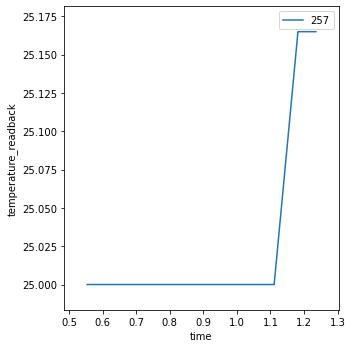

In [4]:
RE(bp.count([temperature], num=10))

Do all the readings look the same?  Perhaps there are only two different values (first one, then the other)?  That's because our measurements were only *reading* the temperature without waiting for it to update.  The table above showed `temperature_scanning_rate 5` which means the EPICS is only updating every 2 seconds.

In [5]:
temperature.scanning_rate.get(as_string=True)

'2 second'

## Adjust the measurement interval
We need to slow down the measurement to this interval by adding the `delay=2` kwarg, sampling every 2 seconds.



Transient Scan ID: 258     Time: 2021-02-24 09:02:25
Persistent Unique Scan ID: '41c9838f-c017-405a-861c-33b316d9f933'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 09:02:26.3 |             25.16497 |
|         2 | 09:02:28.2 |             24.67377 |
|         3 | 09:02:30.2 |             25.02651 |
|         4 | 09:02:32.2 |             25.20976 |
|         5 | 09:02:34.2 |             25.36145 |
|         6 | 09:02:36.2 |             25.33729 |
|         7 | 09:02:38.2 |             25.07406 |
|         8 | 09:02:40.2 |             25.31224 |
|         9 | 09:02:42.2 |             24.99053 |
|        10 | 09:02:44.2 |             25.37483 |
+-----------+------------+----------------------+
generator count ['41c9838f'] (scan num: 258)


('41c9838f-c017-405a-861c-33b316d9f933',)

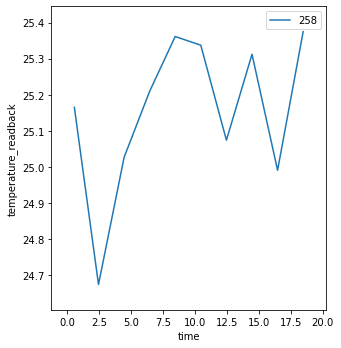

In [6]:
RE(bp.count([temperature], num=10, delay=2))

Let's reduce the update interval that EPICS uses, to the fastest rate EPICS provides, so our measurements do not take so long.

In [7]:
temperature.scanning_rate.put(".1 second")
temperature.scanning_rate.get(as_string=True)

'2 second'

## Collect our measurements
Repeat the measurement, this time with more observations.



Transient Scan ID: 259     Time: 2021-02-24 09:02:46
Persistent Unique Scan ID: 'fb71844a-99bc-423a-a8d2-48b431c386e4'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 09:02:47.6 |             25.17123 |
|         2 | 09:02:47.7 |             24.72649 |
|         3 | 09:02:47.8 |             24.89576 |
|         4 | 09:02:47.9 |             25.38016 |
|         5 | 09:02:48.0 |             24.95042 |
|         6 | 09:02:48.1 |             25.16931 |
|         7 | 09:02:48.2 |             25.21330 |
|         8 | 09:02:48.3 |             25.40199 |
|         9 | 09:02:48.4 |             25.42398 |
|        10 | 09:02:48.5 |             25.13145 |
|        11 | 09:02:48.6 |             24.68871 |
|        12 | 09:02:48.7 |             24.97785 |
|        13 | 09:02:48.8 |             25.22763 |
|        14 | 09:02:48.9 |        

('fb71844a-99bc-423a-a8d2-48b431c386e4',)

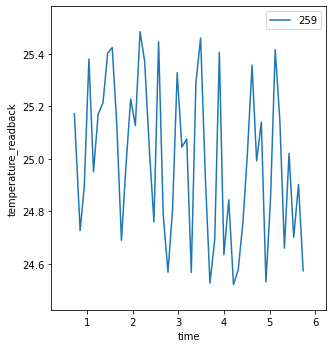

In [8]:
RE(bp.count([temperature], num=50, delay=0.1))

## Get the data (from the database)
Let's get the measured data from the database now.  It's the most recent bluesky run, so an index of `-1` will identify it.

In [9]:
dataset = db.v2[-1].primary.read()

Let's get the values as a 1-D numpy array.

In [10]:
T = dataset["temperature_readback"].values

## Compute the statistics
Use the methods of numpy arrays to compute maximum, mean, standard deviation, and minimum.  Looks nicer in a table.

In [11]:
table = pyRestTable.Table()
table.addLabel("measure")
table.addLabel("value")
table.addRow(("max", T.max()))
table.addRow(("mean", T.mean()))
table.addRow(("dev", T.std()))
table.addRow(("min", T.min()))
table.addRow(("#", len(T)))
print(table)

======= ==================
measure value             
======= ==================
max     25.48406958113985 
mean    24.994084382391083
dev     0.2982934607587424
min     24.520798046845197
#       50                
======= ==================



Let's replot that data for comparison.

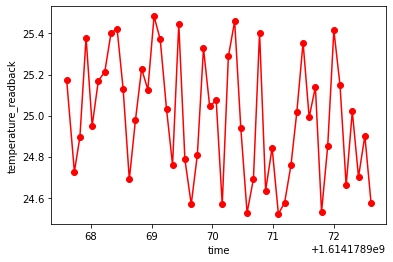

In [12]:
dataset["temperature_readback"].plot(marker="o", color="red")